# Sentiment Analysis of IMDB Reviews - Urvi Vaidya

In [1]:
# We will first donwload the NLTK files and import the necessary libraries.
import nltk
nltk.download('stopwords')
nltk.download('words')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/urvivaidya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/urvivaidya/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/urvivaidya/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
nltk.download()


showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [3]:
import warnings
warnings.filterwarnings("ignore")

# Start with loading all necessary libraries
import numpy as np
import pandas as pd
import os
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk.stem
from nltk.stem import LancasterStemmer
import string
import re # replace of words
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer 
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer 
from afinn import Afinn
from nltk.corpus import sentiwordnet as swn 
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# we will read the data using pandas
reviews =pd.read_csv("~/Downloads/IMDB Dataset.csv")
reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
# lets see the size of the dataset
reviews.shape

(50000, 2)

In [6]:
reviews.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [7]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [8]:
# lets see the number positive and negative sentiments
reviews['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

Some datasets can contain samples with some dirty characters.

 - HTML tags
 - Links
 - Hashtags
 - Emoticons (both in single character :smile: or with composed    characters :) )
 - Non-ascii characters

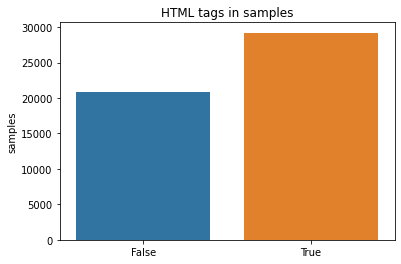

In [9]:
# lets graph the reviews based on the existence of dirty charaters
y_count = reviews['review'].str.contains('<.*?>', regex= True, na=False).value_counts()
sns.barplot(y_count.index,y_count)
plt.gca().set_ylabel('samples')
plt.gca().set_title('HTML tags in samples')

X = reviews['review'].str.replace(r'<.*?>','', regex= True)

In [10]:
# we will read the reviews into a pandas dataframe which will make it easier to work with
data = pd.DataFrame(reviews.review)
data.head()

,review
0,One of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...
2,I thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...
4,"Petter Mattei's ""Love in the Time of Money"" is..."


In [11]:
# lets look at a random review
data.iloc[901,0]

"it got switched off before the opening credits had even finished appearing. The first joke was just so appallingly lame and dreadfully acted that it had to go. You shouldn't really decide to watch this based on my review or not. I saw so little of it I shouldn't even really be commenting but suddenly it all became clear why the video shop guy was sniggering at us paying money to see it.<br /><br />Couldn't they have just made Earnest does Dallas?"

# Cleaning/ Pre-Processing

We start with making all the words lower case

In [12]:
data.review =data.review.str.lower()

In [13]:
# lets check the output
data.iloc[901,0]

"it got switched off before the opening credits had even finished appearing. the first joke was just so appallingly lame and dreadfully acted that it had to go. you shouldn't really decide to watch this based on my review or not. i saw so little of it i shouldn't even really be commenting but suddenly it all became clear why the video shop guy was sniggering at us paying money to see it.<br /><br />couldn't they have just made earnest does dallas?"

We will now work on getting rid of the punctuation

In [14]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [15]:
def remove_punctuation(text):
    text_nopunt="".join([c for c in text if c not in string.punctuation])
    return text_nopunt

In [16]:
data['review']=data['review'].apply(lambda x : remove_punctuation(x))

In [17]:
# lets check the output 
data.iloc[901,0]

'it got switched off before the opening credits had even finished appearing the first joke was just so appallingly lame and dreadfully acted that it had to go you shouldnt really decide to watch this based on my review or not i saw so little of it i shouldnt even really be commenting but suddenly it all became clear why the video shop guy was sniggering at us paying money to see itbr br couldnt they have just made earnest does dallas'

We next get rid of any url's there may be.

In [18]:
data['review']=data['review'].str.replace(r'http\S+|www.\S+','',case=False)

In [19]:
# lets check the output
data.iloc[901,0]

'it got switched off before the opening credits had even finished appearing the first joke was just so appallingly lame and dreadfully acted that it had to go you shouldnt really decide to watch this based on my review or not i saw so little of it i shouldnt even really be commenting but suddenly it all became clear why the video shop guy was sniggering at us paying money to see itbr br couldnt they have just made earnest does dallas'

Removing the numbers

In [21]:
data.iloc[8,0]

'encouraged by the positive comments about this film on here i was looking forward to watching this film bad mistake ive seen 950 films and this is truly one of the worst of them  its awful in almost every way editing pacing storyline acting soundtrack the films only song  a lame country tune  is played no less than four times the film looks cheap and nasty and is boring in the extreme rarely have i been so happy to see the end credits of a film br br the only thing that prevents me giving this a 1score is harvey keitel  while this is far from his best performance he at least seems to be making a bit of an effort one for keitel obsessives only'

In [22]:
data['review']=data['review'].str.replace('\d+','')

In [23]:
# lets check the output
data.iloc[8,0]

'encouraged by the positive comments about this film on here i was looking forward to watching this film bad mistake ive seen  films and this is truly one of the worst of them  its awful in almost every way editing pacing storyline acting soundtrack the films only song  a lame country tune  is played no less than four times the film looks cheap and nasty and is boring in the extreme rarely have i been so happy to see the end credits of a film br br the only thing that prevents me giving this a score is harvey keitel  while this is far from his best performance he at least seems to be making a bit of an effort one for keitel obsessives only'

Removing Stop Words - this is where we start processing the data.

In [24]:
# Import stopwords with nltk.
stop = stopwords.words('english')
stop

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [25]:
# lets look at the output
data.iloc[901,0]

'it got switched off before the opening credits had even finished appearing the first joke was just so appallingly lame and dreadfully acted that it had to go you shouldnt really decide to watch this based on my review or not i saw so little of it i shouldnt even really be commenting but suddenly it all became clear why the video shop guy was sniggering at us paying money to see itbr br couldnt they have just made earnest does dallas'

In [26]:
# Exclude stopwords with Python's list comprehension and pandas.DataFrame.apply.
data['review']=data['review'].apply(lambda x: ' '.join([word for word in x.split() #
                                                      if word not in (stop)]))

In [27]:
data.iloc[901,0]

'got switched opening credits even finished appearing first joke appallingly lame dreadfully acted go shouldnt really decide watch based review saw little shouldnt even really commenting suddenly became clear video shop guy sniggering us paying money see itbr br couldnt made earnest dallas'

Removing the Common Words

In [28]:
words = set(nltk.corpus.words.words())
words

{'toxophoric',
 'heterogeneously',
 'impoverisher',
 'overcherish',
 'restrictedness',
 'chthonophagia',
 'reactive',
 'tauromorphous',
 'brewery',
 'toxicoid',
 'removability',
 'outseek',
 'protoforester',
 'traversewise',
 'unrecordable',
 'Macrotolagus',
 'practicer',
 'strip',
 'metanephritic',
 'tebbet',
 'dorsiventrally',
 'interjector',
 'bothsidedness',
 'cosinage',
 'imitationist',
 'hartshorn',
 'palaverist',
 'submucronate',
 'characterful',
 'deliberate',
 'Huxleian',
 'montbretia',
 'trochiscation',
 'unheralded',
 'suppositively',
 'ariel',
 'forehill',
 'crustade',
 'hyalobasalt',
 'Siping',
 'alcogel',
 'isopleth',
 'undrab',
 'galvanized',
 'paleopathology',
 'supraglenoid',
 'Meckelian',
 'Tzapotec',
 'ovated',
 'unheedingly',
 'orthodomatic',
 'pantellerite',
 'kernelless',
 'contrition',
 'sexualism',
 'atomically',
 'cinurous',
 'isocheim',
 'acreage',
 'dokhma',
 'oculinid',
 'mokaddam',
 'clothier',
 'lug',
 'opticist',
 'steatopyga',
 'Zannichellia',
 'Cana',
 

In [29]:
# Apply a second round of cleaning
def clean_text_round2(text):
    '''Get rid of some additional punctuation and non-sensical text that was missed the first time around.'''
    text =  re.sub('delhipolicetorturingfarmers|delhipolice|police|delhi', '', text) #remove delhipolice
    text =  re.sub('farmer|farmers|farm|farmed','', text) #remove farmers
    text =  re.sub('protests|protest','', text) #remove Protest
    text =  re.sub(r"\b[a-zA-Z]\b", "", text) ## 1 alphabet like a or s
    text =  re.sub(r"\b[a-zA-Z][a-zA-Z]\b", "", text)  ## 2 alphabet like ab or ad 
    text =  " ".join(w for w in nltk.wordpunct_tokenize(text)  ## this will give you tokens 
                    if w.lower() in words)  #    
    return text

round2 = lambda x: clean_text_round2(x)

In [30]:
# Let's take a look at the updated text
data['review']=data['review'].apply(lambda x : clean_text_round2(x))
data = pd.DataFrame(data.review.apply(round2))
# checking the output
data.iloc[901,0]

'got switched opening even finished first joke appallingly lame dreadfully shouldnt really decide watch based review saw little shouldnt even really suddenly clear video shop guy sniggering paying money see made earnest'

STEMMING

In [31]:
# the most commonly used stemmer is the Snowball Stemmer
ss = SnowballStemmer("english")
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

# creating the stemming function
def SnowballStemmer_text(text):
    return [ss.stem(w) for w in w_tokenizer.tokenize(text)]

data.head()

,review
0,one watching episode hooked right exactly firs...
1,wonderful little production technique unassumi...
2,thought wonderful way spend time hot summer we...
3,basically theres family little boy jake theres...
4,petter love time money visually stunning film ...


In [32]:
# running the stemming function
data['review'] = data.review.apply(lambda x :' '.join(SnowballStemmer_text(x)))
data.head()

,review
0,one watch episod hook right exact first thing ...
1,wonder littl product techniqu unassum fashion ...
2,thought wonder way spend time hot summer weeke...
3,basic there famili littl boy jake there zombi ...
4,petter love time money visual stun film watch ...


In [33]:
# lets check the output
data.iloc[901,0]

'got switch open even finish first joke appal lame dread shouldnt realli decid watch base review saw littl shouldnt even realli sudden clear video shop guy snigger pay money see made earnest'

LEMMATIZATION

In [34]:
# Initiating the Wordnet Lemmatizer
lemmatizer = WordNetLemmatizer()
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()

In [35]:
# creating the lemmatizing function
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w,"v") for w in w_tokenizer.tokenize(text)]

In [36]:
data.iloc[901,0]

'got switch open even finish first joke appal lame dread shouldnt realli decid watch base review saw littl shouldnt even realli sudden clear video shop guy snigger pay money see made earnest'

In [37]:
# running the lemmatizing function
data['review'] = data.review.apply(lambda x :' '.join(lemmatize_text(x)))

# checking the output
data.iloc[901,0]

'get switch open even finish first joke appal lame dread shouldnt realli decid watch base review saw littl shouldnt even realli sudden clear video shop guy snigger pay money see make earnest'

STRIPPING THE EXTRA WHITE SPACES

In [38]:
data.iloc[901,0]

'get switch open even finish first joke appal lame dread shouldnt realli decid watch base review saw littl shouldnt even realli sudden clear video shop guy snigger pay money see make earnest'

In [39]:
data['review'] = (data['review'].astype("str").str.rstrip())
data.iloc[901,0]

'get switch open even finish first joke appal lame dread shouldnt realli decid watch base review saw littl shouldnt even realli sudden clear video shop guy snigger pay money see make earnest'

# Term Document Matrix
- Now that we have finished cleaning and pre-processing the data we will move on to its Analysis.

In [40]:
# We are going to create a document-term matrix using CountVectorizer, and exclude common English stop words
cv = CountVectorizer(stop_words='english')
data_cv = cv.fit_transform(data.review)
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())

# One of the required inputs is a term-document matrix
tdm = data_dtm.transpose()
tdm.head()

,0,1,2,3,4,5,6,7,8,9,...,49990,49991,49992,49993,49994,49995,49996,49997,49998,49999
aardvark,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aba,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aback,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abandon,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
abash,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
tdm['freq'] = tdm.sum(axis=1)
tdm.head()

,0,1,2,3,4,5,6,7,8,9,...,49991,49992,49993,49994,49995,49996,49997,49998,49999,freq
aardvark,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
aba,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
aback,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,19
abandon,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,479
abash,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [42]:
tdm.reset_index(inplace=True)
tdm.head()

,index,0,1,2,3,4,5,6,7,8,...,49991,49992,49993,49994,49995,49996,49997,49998,49999,freq
0,aardvark,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
1,aba,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,aback,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,19
3,abandon,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,479
4,abash,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [43]:
# lets look at the frequecy distribution of the review words
tdm1=tdm[["index","freq"]]
tdm1.rename(columns = {'index':'Word'}, inplace = True)
tdm1.sort_values(by='freq',ascending=False,inplace=True)
tdm1.head(20)

,Word,freq
11628,movi,83529
6567,film,74474
10320,like,40111
10725,make,35699
18777,time,29808
7607,good,28981
20874,watch,27035
18645,think,23321
14746,realli,22950
17666,stori,22104


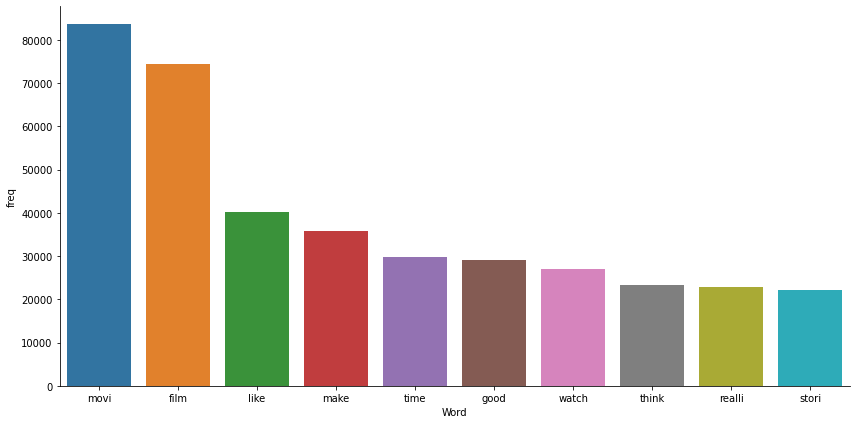

In [44]:
# visualizing the highest frequency words 
w = tdm1[tdm1['freq'] >=20000] 
fg = sns.factorplot(x='Word', y='freq',
                        size=6,  aspect=2,
                        kind='bar', 
                        data=w)

# Word Cloud 

In [45]:
text = " ".join(review for review in data.review)
print ("There are {} words in the combination of all review.".format(len(text)))

There are 26104884 words in the combination of all review.


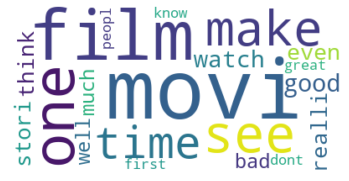

In [46]:
## collocations=False means try to contro the duplicate keyword and counts as 1
# lower max_font_size, change the maximum number of word and lighten the background:

stopwords = set(STOPWORDS)
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords,
                      background_color="white",
                      collocations=False,
                       max_words=20).generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Sentiment Analysis 

In [48]:
# Create quick lambda functions to find the polarity and subjectivity of each routine
pol = lambda x: TextBlob(x).sentiment.polarity # polarity range -1 to +1
data['polarity'] = data['review'].apply(pol)
data.head(5)

,review,polarity
0,one watch episod hook right exact first thing ...,0.017143
1,wonder littl product techniqu unassum fashion ...,0.215476
2,think wonder way spend time hot summer weekend...,0.358929
3,basic there famili littl boy jake there zombi ...,-0.007143
4,petter love time money visual stun film watch ...,0.193974


In [49]:
data['Sentiment1'] = np.where(data['polarity']>= 0, 'Positive', 'Negative')
data.head()

,review,polarity,Sentiment1
0,one watch episod hook right exact first thing ...,0.017143,Positive
1,wonder littl product techniqu unassum fashion ...,0.215476,Positive
2,think wonder way spend time hot summer weekend...,0.358929,Positive
3,basic there famili littl boy jake there zombi ...,-0.007143,Negative
4,petter love time money visual stun film watch ...,0.193974,Positive


<AxesSubplot:>

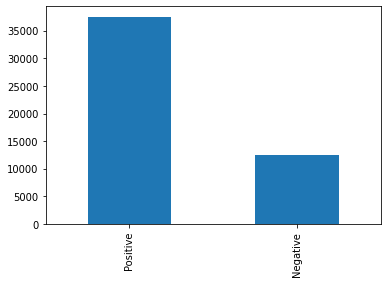

In [50]:
data.Sentiment1.value_counts().plot.bar()

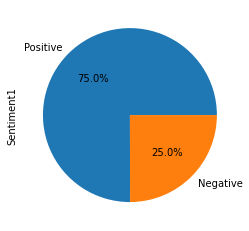

In [51]:
data.Sentiment1.value_counts().plot.pie(autopct="%.1f%%");

In [52]:
data['Sentiment2'] = np.where(data['polarity']< 0,  'Negative',
                             np.where(data['polarity'] > 0,'Positive', 'Neutral'))
data.head()

,review,polarity,Sentiment1,Sentiment2
0,one watch episod hook right exact first thing ...,0.017143,Positive,Positive
1,wonder littl product techniqu unassum fashion ...,0.215476,Positive,Positive
2,think wonder way spend time hot summer weekend...,0.358929,Positive,Positive
3,basic there famili littl boy jake there zombi ...,-0.007143,Negative,Negative
4,petter love time money visual stun film watch ...,0.193974,Positive,Positive


<AxesSubplot:>

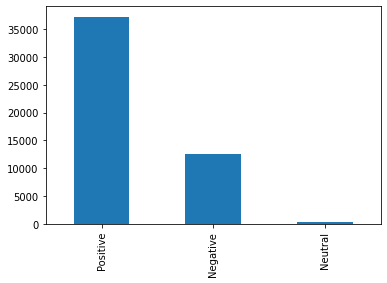

In [53]:
data.Sentiment2.value_counts().plot.bar()

In [54]:
data['tokenized_words'] = data['review'].apply(lambda x: x.split())
data.head()

,review,polarity,Sentiment1,Sentiment2,tokenized_words
0,one watch episod hook right exact first thing ...,0.017143,Positive,Positive,"[one, watch, episod, hook, right, exact, first..."
1,wonder littl product techniqu unassum fashion ...,0.215476,Positive,Positive,"[wonder, littl, product, techniqu, unassum, fa..."
2,think wonder way spend time hot summer weekend...,0.358929,Positive,Positive,"[think, wonder, way, spend, time, hot, summer,..."
3,basic there famili littl boy jake there zombi ...,-0.007143,Negative,Negative,"[basic, there, famili, littl, boy, jake, there..."
4,petter love time money visual stun film watch ...,0.193974,Positive,Positive,"[petter, love, time, money, visual, stun, film..."


# Using TfidfVectorizer

In [55]:
# settings that you use for count vectorizer will go here 
tfidf_vectorizer=TfidfVectorizer(use_idf=True,stop_words='english',analyzer='word') 
 
# just send in all your docs here 
tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(data.review)
feature_names = cv.get_feature_names()  ## EVERY WORD NAME

In [56]:
output=pd.DataFrame.sparse.from_spmatrix(tfidf_vectorizer_vectors,columns=feature_names)
output

,aardvark,aba,aback,abandon,abash,abat,abba,abbasi,abbey,abbot,...,zoetrop,zoid,zombi,zone,zonelik,zoo,zoolog,zoologist,zoom,zorro
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.137526,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
max_value = output.max()
print(max_value)

aardvark     0.490548
aba          0.204959
aback        0.248349
abandon      0.342245
abash        0.289005
               ...   
zoo          0.358672
zoolog       0.158614
zoologist    0.264847
zoom         0.592212
zorro        0.759243
Length: 21505, dtype: float64


In [58]:
afn = Afinn()
sentiment_polarity = [afn.score(review) for review in data.review] 
data['Sentiment_Score']=sentiment_polarity
data.head()

,review,polarity,Sentiment1,Sentiment2,tokenized_words,Sentiment_Score
0,one watch episod hook right exact first thing ...,0.017143,Positive,Positive,"[one, watch, episod, hook, right, exact, first...",-19.0
1,wonder littl product techniqu unassum fashion ...,0.215476,Positive,Positive,"[wonder, littl, product, techniqu, unassum, fa...",10.0
2,think wonder way spend time hot summer weekend...,0.358929,Positive,Positive,"[think, wonder, way, spend, time, hot, summer,...",1.0
3,basic there famili littl boy jake there zombi ...,-0.007143,Negative,Negative,"[basic, there, famili, littl, boy, jake, there...",-4.0
4,petter love time money visual stun film watch ...,0.193974,Positive,Positive,"[petter, love, time, money, visual, stun, film...",18.0


<AxesSubplot:>

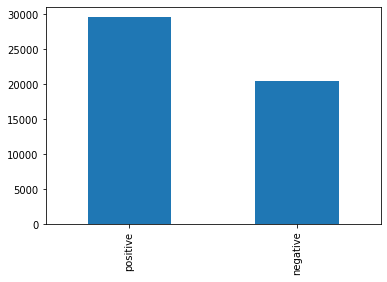

In [59]:
predicted_sentiments = ['positive' if score > 2 else 'negative' for score in sentiment_polarity] 
data['Sentiment2']=predicted_sentiments 
data.head()
data.Sentiment2.value_counts().plot.bar()

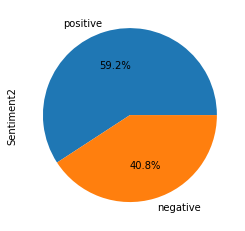

In [60]:
data.Sentiment2.value_counts().plot.pie(autopct="%.1f%%");

In [61]:
data.head()

,review,polarity,Sentiment1,Sentiment2,tokenized_words,Sentiment_Score
0,one watch episod hook right exact first thing ...,0.017143,Positive,negative,"[one, watch, episod, hook, right, exact, first...",-19.0
1,wonder littl product techniqu unassum fashion ...,0.215476,Positive,positive,"[wonder, littl, product, techniqu, unassum, fa...",10.0
2,think wonder way spend time hot summer weekend...,0.358929,Positive,negative,"[think, wonder, way, spend, time, hot, summer,...",1.0
3,basic there famili littl boy jake there zombi ...,-0.007143,Negative,negative,"[basic, there, famili, littl, boy, jake, there...",-4.0
4,petter love time money visual stun film watch ...,0.193974,Positive,positive,"[petter, love, time, money, visual, stun, film...",18.0
